In [1]:
import scperturb as scp 
import urllib.request
import os
import scanpy as sc 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sbn
from gsnn_lib.proc import omnipath 
import pandas as pd
import torch

from gsnn.models.GSNN import GSNN 
from gsnn.models.NN import NN
from hnet.models.HyperNet import HyperNet

from gsnn_lib.proc.sc.load import get_SrivatsanTrapnell2020, get_AissaBenevolenskaya2021, load_scp_dataset
from gsnn_lib.data.scSampler import scSampler

from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score

from hnet.train.hnet import init_hnet

import umap
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import gc 
from scipy.stats import ks_2samp, mannwhitneyu

from geomloss import SamplesLoss
from scipy.stats import wasserstein_distance_nd

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/gsnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fnames = os.listdir('../../sc_data/PROC/')
drugs = np.unique([f.split('_')[2] for f in fnames])[:-1] 
data = torch.load('../../sc_data/' + 'data.pt')

In [3]:
res_dict = torch.load('../../sc_output/res_dict.pt')
sampler = res_dict['sampler']
os.chdir('../')
T = res_dict['T']
args = res_dict['args']
device = 'cuda'

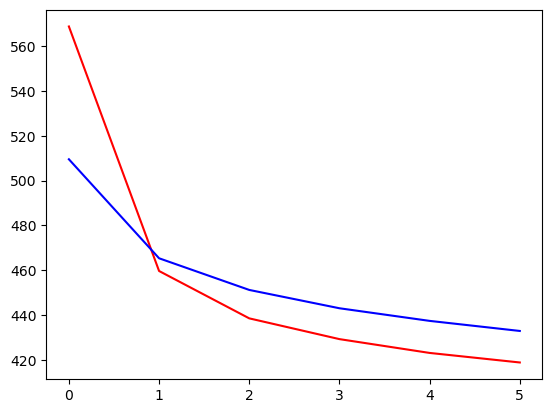

In [4]:
plt.figure()
plt.plot(res_dict['train_losses'], 'r-', label='train')
plt.plot(res_dict['val_losses'], 'b-', label='val')
plt.legend()
plt.show()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


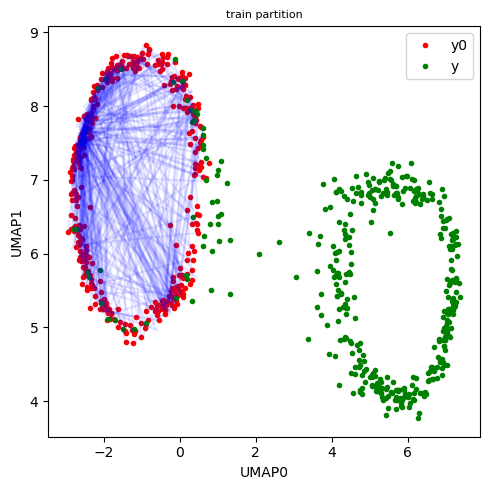

In [5]:
#BRD-K56957086, MCF7, 10000.0
#idd = sampler.conditions[lambda x: (x.drug == 'BRD-K56957086') & (x.cell_line == 'MCF7.') & (x.dose == 10000.0)].index[0]
idd = sampler.conditions[lambda x: (x.drug == 'BRD-K56957086') & (x.cell_line == 'MCF7.') & (x.dose == 10000.0)].index[0]
X,y = sampler.sample(idd, batch_size=500, partition='train')

with torch.no_grad():
    y0 = X[:, data.X2Y0_idxs]
    yhat = [] 
    for idx in torch.split(torch.arange(X.shape[0]), 50):
        yhat.append(T(X[idx].cuda()).detach().cpu())
    yhat = torch.cat(yhat) + y0

reducer = umap.UMAP()
reducer.fit(torch.cat([y0, y]).detach().cpu().numpy())
pc_y0 = reducer.transform(y0.detach().cpu().numpy())
pc_y = reducer.transform(y.detach().cpu().numpy())
pc_yhat = reducer.transform(yhat.detach().cpu().numpy())

f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax = [ax]
ax[0].plot(pc_y0[:, 0], pc_y0[:, 1], 'r.', label='y0')
ax[0].plot(pc_y[:, 0], pc_y[:, 1], 'g.', label='y')
for ii in range(pc_y0.shape[0]): 
    ax[0].plot((pc_y0[ii, 0], pc_yhat[ii, 0]), (pc_y0[ii, 1], pc_yhat[ii, 1]), 'b-', alpha=0.1)
ax[0].set_xlabel('UMAP0')
ax[0].set_ylabel('UMAP1')
ax[0].set_title(f'train partition', fontsize=8)
ax[0].legend()

plt.tight_layout()
plt.show()

In [ ]:
res = {'drug': [], 'cell_line': [], 'dose': [], 'shd': [], 'emmd': [], 'gmmd': [], 'n':[], 'wass':[], 'condition':[], 'shd0':[], 'emmd0':[], 'gmmd0':[], 'wass0':[], 'dbar':[]}

SHD = SamplesLoss('sinkhorn', p=2, blur=0.05, reach=None)
eMMD = SamplesLoss('energy') 
gMMD = SamplesLoss('gaussian', blur=0.05) 

for i in range(len(sampler)):
    print(f'progress: {i}/{len(sampler)}', end='\r')

    cond = sampler.conditions.iloc[i]
    drg_ = cond.drug 
    cell_ = cond.cell_line 
    dose_ = cond.dose

    with torch.no_grad():
        X,y = sampler.sample(i, batch_size=500, partition='test')
        y0 = X[:, data.X2Y0_idxs]
        yhat = [] 
        for idx in torch.split(torch.arange(X.shape[0]), 50):
            yhat.append(T(X[idx].cuda()).detach().cpu())
        yhat = torch.cat(yhat) + y0

    dbar = torch.mean((y.mean(0) - y0.mean(0))**2).item()*(0.5)

    shd = SHD(y, yhat).item()
    emmd = eMMD(y, yhat).item()
    gmmd = gMMD(y, yhat).item()
    wass = wasserstein_distance_nd(y.numpy(), yhat.numpy())

    shd0 = SHD(y, y0).item()
    emmd0 = eMMD(y, y0).item()
    gmmd0 = gMMD(y, y0).item()
    wass0 = wasserstein_distance_nd(y.numpy(), y0.numpy())

    res['drug'].append(drg_)
    res['cell_line'].append(cell_)
    res['dose'].append(dose_)
    res['condition'].append(i)

    res['shd'].append(shd)
    res['emmd'].append(emmd)
    res['gmmd'].append(gmmd)
    res['wass'].append(wass)

    res['n'].append(X.shape[0])
    res['dbar'].append(dbar)

    res['shd0'].append(shd0)
    res['emmd0'].append(emmd0)
    res['gmmd0'].append(gmmd0)
    res['wass0'].append(wass0)

    del X, y, y0, yhat

res = pd.DataFrame(res)
res.head()

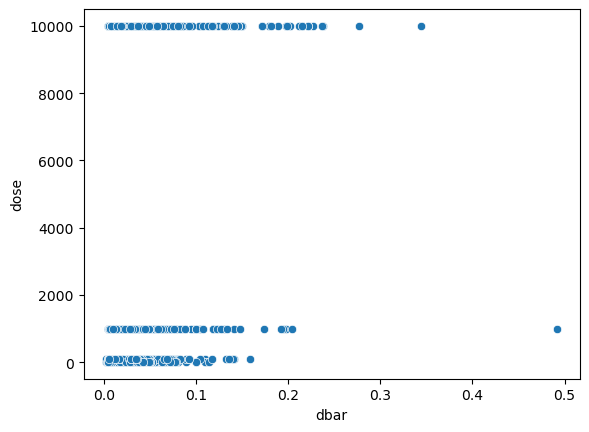

In [6]:
plt.figure()
sbn.scatterplot(data=res, x='dbar', y='dose')
plt.show()

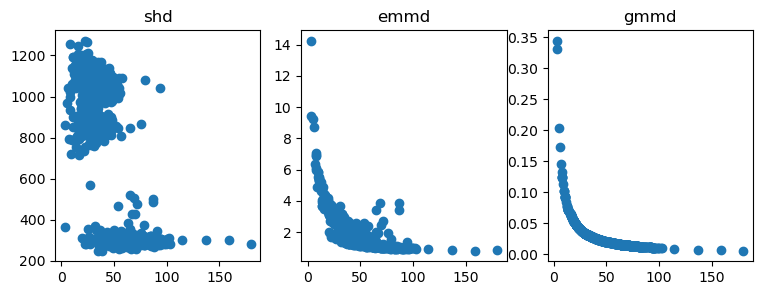

In [7]:
f,axes = plt.subplots(1,3, figsize=(9,3))
for i,metric in enumerate(['shd', 'emmd', 'gmmd']):
    axes[i].scatter(res['n'], res[metric])
    axes[i].set_title(metric)

plt.show()

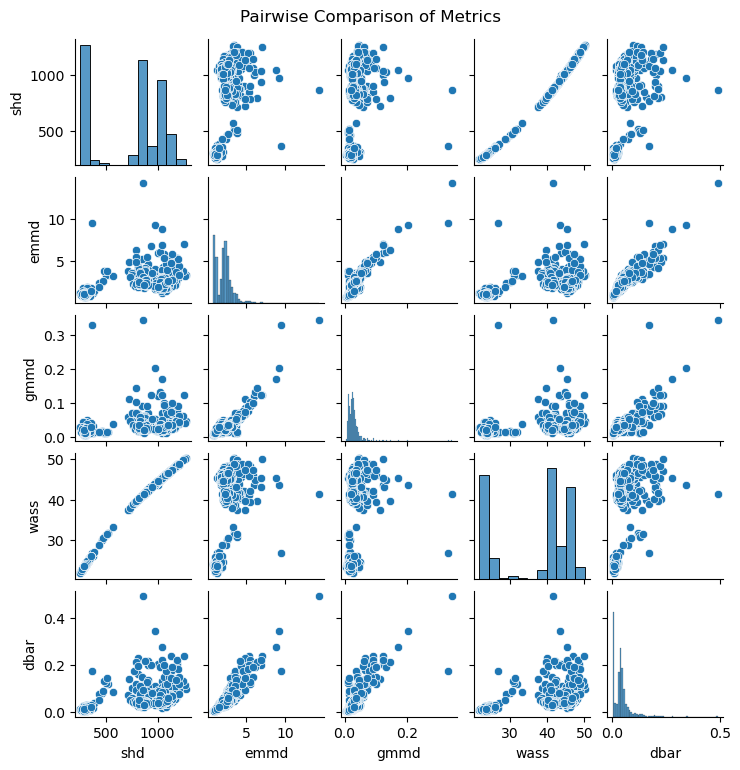

In [8]:
# Create a pairplot to compare each metric to each other
sbn.pairplot(res[['shd', 'emmd', 'gmmd', 'wass', 'dbar']], height=1.5)
plt.suptitle('Pairwise Comparison of Metrics', y=1.02)
plt.show()

In [9]:
res[lambda x: x.n > 25].sort_values('shd', ascending=True).head()

,drug,cell_line,dose,shd,emmd,gmmd,n,wass,condition,shd0,emmd0,gmmd0,wass0,dbar
41,BRD-A60197193,MCF7.,100.0,248.453964,1.286280,0.025688,39,21.869971,41,243.761520,0.638805,0.025650,21.641776,0.008961
692,BRD-K71512533,MCF7.,1000.0,249.440582,1.329420,0.028596,35,21.955620,692,243.773956,0.690132,0.028661,21.630770,0.011324
272,BRD-K15574380,MCF7.,1000.0,258.156860,1.017563,0.015146,66,22.331235,272,246.594330,0.343794,0.015136,21.790010,0.005382
617,BRD-K55187425,MCF7.,100.0,258.276428,1.087606,0.018219,55,22.198755,617,253.715469,0.455963,0.018223,21.884191,0.007778
917,BRD-K97399794,MCF7.,100.0,259.466858,1.042763,0.014078,71,22.380618,917,241.725525,0.332218,0.014109,21.604063,0.005565


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


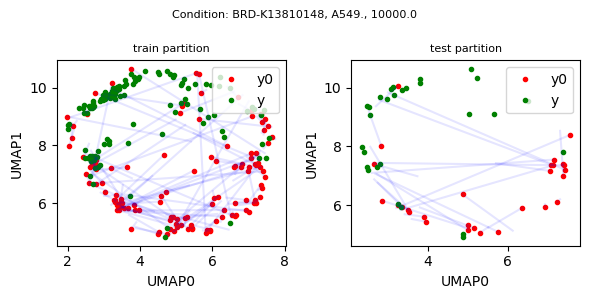

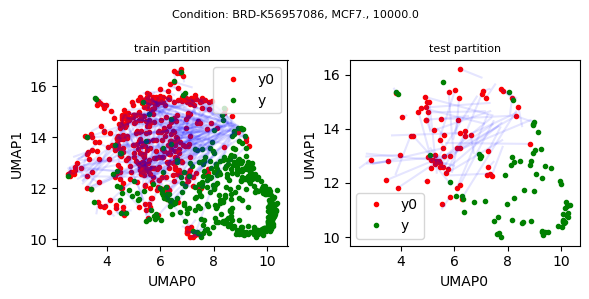

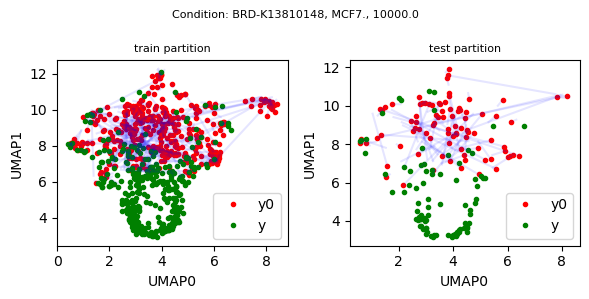

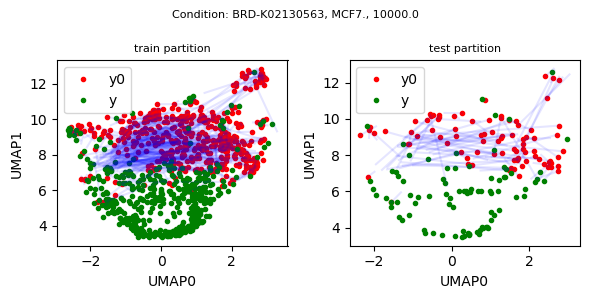

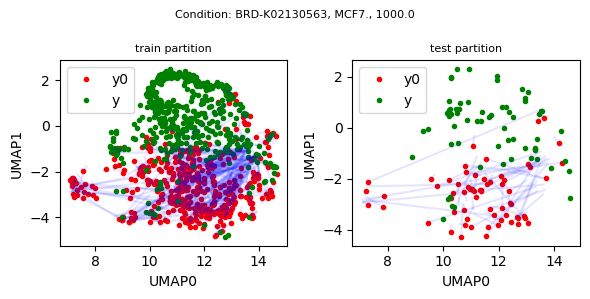

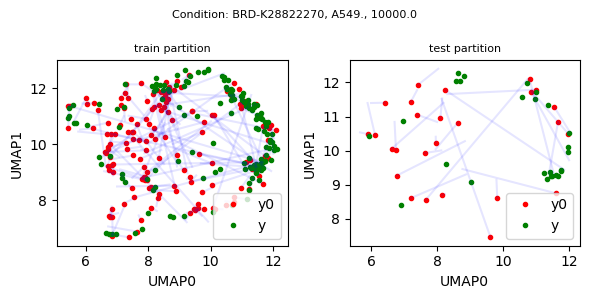

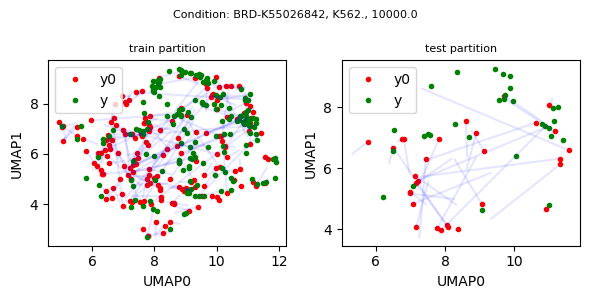

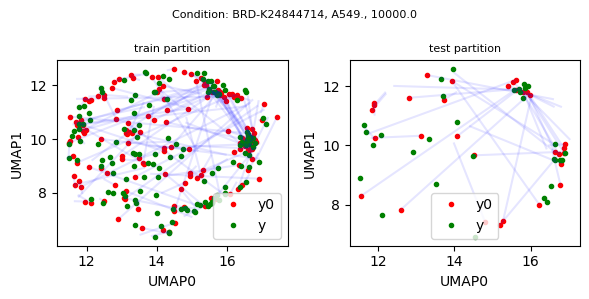

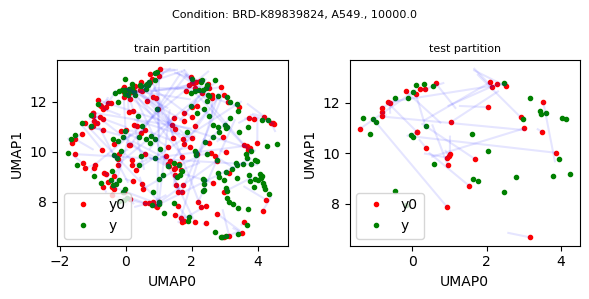

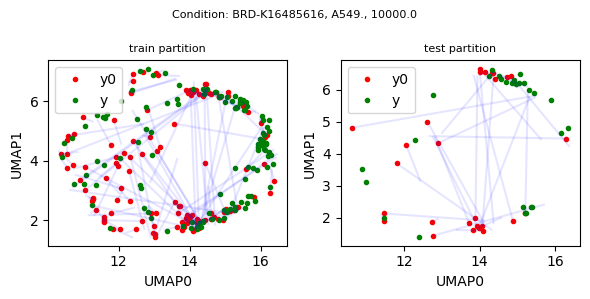

In [10]:
# todo: PLOT TRAIN/TEST

# strong perturbation conditions 
conds = res[lambda x: x.n > 25].sort_values('dbar', ascending=False).condition.values[0:10]
#conds = res[lambda x: x.n > 25].sort_values('shd', ascending=True).condition.values[0:10]

for i in conds: # range(len(sampler))[:1]:

    cond = sampler.conditions.iloc[i]
    drg_ = cond.drug 
    cell_ = cond.cell_line 
    dose_ = cond.dose

    with torch.no_grad():
        X,y = sampler.sample(i, batch_size=500, partition='train')
        Xt,yt = sampler.sample(i, batch_size=500, partition='test')

        delta = []
        for idx in torch.split( torch.arange(X.shape[0]), 50):
            #delta.append(T(X[idx].to(device), samples=10).mean(0).cpu())
            delta.append(T(X[idx].to(device)).cpu())
        delta = torch.cat(delta, dim=0)

        deltat = []
        for idx in torch.split( torch.arange(Xt.shape[0]), 50):
            #delta.append(T(X[idx].to(device), samples=10).mean(0).cpu())
            deltat.append(T(Xt[idx].to(device)).cpu())
        deltat = torch.cat(deltat, dim=0)

    y0 = X[:, data.X2Y0_idxs].detach().cpu().numpy() 
    y = y.detach().cpu().numpy()
    yhat = delta.detach().cpu().numpy() + y0

    y0t = Xt[:, data.X2Y0_idxs].detach().cpu().numpy() 
    yt = yt.detach().cpu().numpy()
    yhatt = deltat.detach().cpu().numpy() + y0t

    # dim red on each condition to better separate perturbation effects 
    # fit on training data (more available)
    # NOTE: using supervised umap to better separate pre- / post- perturbation states - otherwise cell cycle is often a primary source of variance 
    reducer = umap.UMAP(n_components=2)
    target = np.concatenate((np.ones_like(y0[:, 0]), np.zeros_like(y[:, 0])), axis=0)
    #pcs = reducer.fit(np.concatenate([y0, y], axis=0), y=target)
    pcs = reducer.fit(np.concatenate([y0, y, yhat], axis=0))

    pc_y0 = reducer.transform(y0)
    pc_y = reducer.transform(y)
    pc_yhat = reducer.transform(yhat)

    pc_y0t = reducer.transform(y0t)
    pc_yt = reducer.transform(yt)
    pc_yhatt = reducer.transform(yhatt)

    f, ax = plt.subplots(1, 2, figsize=(6, 3))
    
    ax[0].plot(pc_y0[:, 0], pc_y0[:, 1], 'r.', label='y0')
    ax[0].plot(pc_y[:, 0], pc_y[:, 1], 'g.', label='y')
    for ii in range(pc_y0.shape[0]): 
        ax[0].plot((pc_y0[ii, 0], pc_yhat[ii, 0]), (pc_y0[ii, 1], pc_yhat[ii, 1]), 'b-', alpha=0.1)
    ax[0].set_xlabel('UMAP0')
    ax[0].set_ylabel('UMAP1')
    ax[0].set_title(f'train partition', fontsize=8)
    ax[0].legend()

    ax[1].plot(pc_y0t[:, 0], pc_y0t[:, 1], 'r.', label='y0')
    ax[1].plot(pc_yt[:, 0], pc_yt[:, 1], 'g.', label='y')
    for ii in range(pc_y0t.shape[0]): 
        ax[1].plot((pc_y0t[ii, 0], pc_yhatt[ii, 0]), (pc_y0t[ii, 1], pc_yhatt[ii, 1]), 'b-', alpha=0.1)
    ax[1].set_xlabel('UMAP0')
    ax[1].set_ylabel('UMAP1')
    ax[1].set_title(f'test partition', fontsize=8)
    ax[1].legend()

    plt.suptitle(f'Condition: {drg_}, {cell_}, {dose_}', fontsize=8)

    plt.tight_layout()
    plt.show()


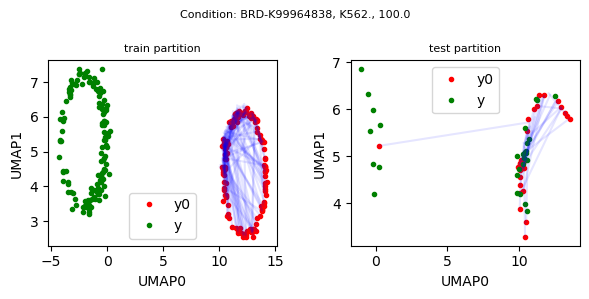

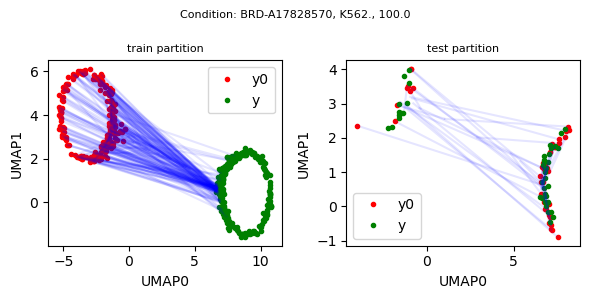

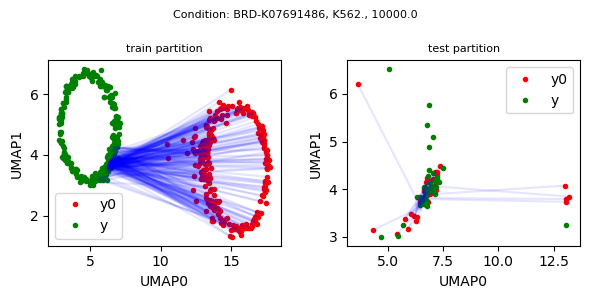

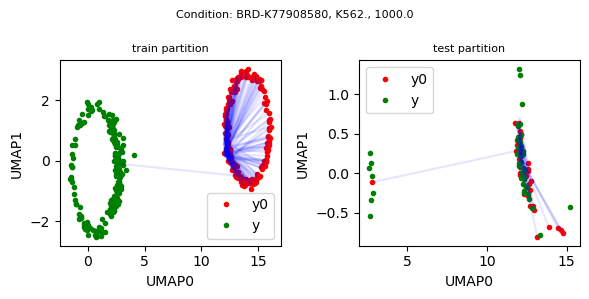

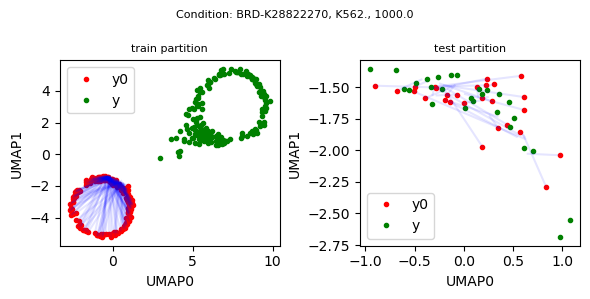

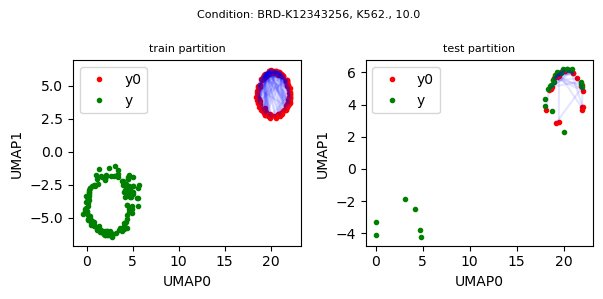

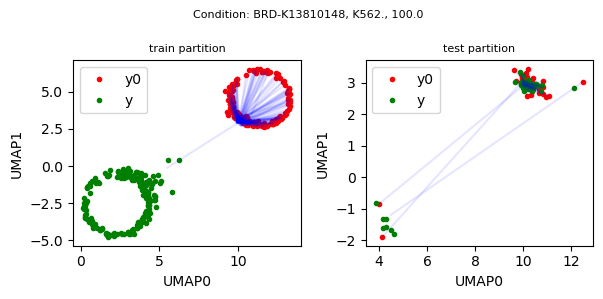

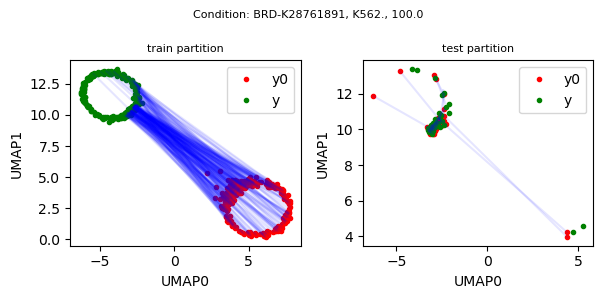

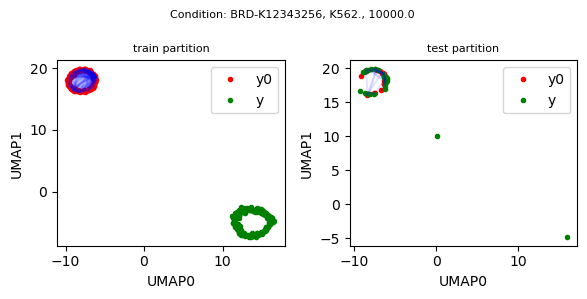

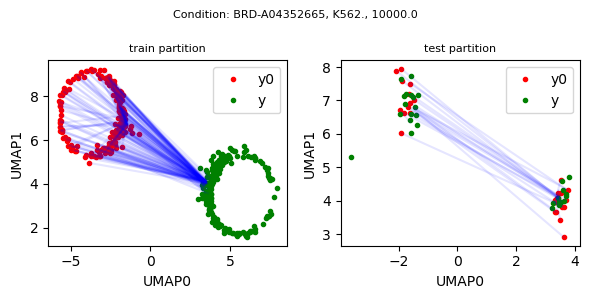

In [11]:
# todo: PLOT TRAIN/TEST

# strong perturbation conditions 
#conds = res[lambda x: x.n > 25].sort_values('dbar', ascending=False).condition.values[0:3]
conds = res[lambda x: x.n > 25].sort_values('shd', ascending=True).condition.values[-10:]

for i in conds: # range(len(sampler))[:1]:

    cond = sampler.conditions.iloc[i]
    drg_ = cond.drug 
    cell_ = cond.cell_line 
    dose_ = cond.dose

    with torch.no_grad():
        X,y = sampler.sample(i, batch_size=500, partition='train')
        Xt,yt = sampler.sample(i, batch_size=500, partition='test')

        delta = []
        for idx in torch.split( torch.arange(X.shape[0]), 50):
            #delta.append(T(X[idx].to(device), samples=10).mean(0).cpu())
            delta.append(T(X[idx].to(device)).cpu())
        delta = torch.cat(delta, dim=0)

        deltat = []
        for idx in torch.split( torch.arange(Xt.shape[0]), 50):
            #delta.append(T(X[idx].to(device), samples=10).mean(0).cpu())
            deltat.append(T(Xt[idx].to(device)).cpu())
        deltat = torch.cat(deltat, dim=0)

    y0 = X[:, data.X2Y0_idxs].detach().cpu().numpy() 
    y = y.detach().cpu().numpy()
    yhat = delta.detach().cpu().numpy() + y0

    y0t = Xt[:, data.X2Y0_idxs].detach().cpu().numpy() 
    yt = yt.detach().cpu().numpy()
    yhatt = deltat.detach().cpu().numpy() + y0t

    # dim red on each condition to better separate perturbation effects 
    # fit on training data (more available)
    # NOTE: using supervised umap to better separate pre- / post- perturbation states - otherwise cell cycle is often a primary source of variance 
    reducer = umap.UMAP(n_components=2)
    target = np.concatenate((np.ones_like(y0[:, 0]), np.zeros_like(y[:, 0])), axis=0)
    pcs = reducer.fit(np.concatenate([y0, y], axis=0), y=target)

    pc_y0 = reducer.transform(y0)
    pc_y = reducer.transform(y)
    pc_yhat = reducer.transform(yhat)

    pc_y0t = reducer.transform(y0t)
    pc_yt = reducer.transform(yt)
    pc_yhatt = reducer.transform(yhatt)

    f, ax = plt.subplots(1, 2, figsize=(6, 3))
    
    ax[0].plot(pc_y0[:, 0], pc_y0[:, 1], 'r.', label='y0')
    ax[0].plot(pc_y[:, 0], pc_y[:, 1], 'g.', label='y')
    for ii in range(pc_y0.shape[0]): 
        ax[0].plot((pc_y0[ii, 0], pc_yhat[ii, 0]), (pc_y0[ii, 1], pc_yhat[ii, 1]), 'b-', alpha=0.1)
    ax[0].set_xlabel('UMAP0')
    ax[0].set_ylabel('UMAP1')
    ax[0].set_title(f'train partition', fontsize=8)
    ax[0].legend()

    ax[1].plot(pc_y0t[:, 0], pc_y0t[:, 1], 'r.', label='y0')
    ax[1].plot(pc_yt[:, 0], pc_yt[:, 1], 'g.', label='y')
    for ii in range(pc_y0t.shape[0]): 
        ax[1].plot((pc_y0t[ii, 0], pc_yhatt[ii, 0]), (pc_y0t[ii, 1], pc_yhatt[ii, 1]), 'b-', alpha=0.1)
    ax[1].set_xlabel('UMAP0')
    ax[1].set_ylabel('UMAP1')
    ax[1].set_title(f'test partition', fontsize=8)
    ax[1].legend()

    plt.suptitle(f'Condition: {drg_}, {cell_}, {dose_}', fontsize=8)

    plt.tight_layout()
    plt.show()